In [1]:
# Upload dataset to your google drive. Use data from drive for experiments/development.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import all required libraries here.

import zipfile
import os
from io import BytesIO
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import math
import numpy as np

In [3]:
# global variables and constants
CLOSET_GPT_PATH = '/content/drive/MyDrive/ClosetGPT'
MARYLAND_DATASET = 'Re-PolyVore.zip'
MARYLAND_DATASET_PATH = CLOSET_GPT_PATH + '/' + MARYLAND_DATASET

# index of label in directory structure
LABEL_IDX = 1

BATCH_SIZE = 16

In [4]:
#
# Display available labels in Maryland dataset.
# Two dicts are returned:
#   label_dict: {label (str) : category (int)
#   rev_label_dict: {category (int) : label (str)
#
def get_maryland_labels(data=MARYLAND_DATASET_PATH):
  with zipfile.ZipFile(data, 'r') as zip_ref:
    file_list = [f for f in zip_ref.namelist() if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    unique_labels = sorted(set(f.split('/')[LABEL_IDX] for f in file_list if '/' in f))
    unique_labels.remove('Re-PolyVore')
    labels_dict = {label: idx for idx, label in enumerate(unique_labels)}
    rev_labels_dict = {idx: label for idx, label in enumerate(unique_labels)}
  return labels_dict, rev_labels_dict

labels_dict, rev_labels_dict = get_maryland_labels()
print(labels_dict)
print(rev_labels_dict)

{'bag': 0, 'bracelet': 1, 'brooch': 2, 'dress': 3, 'earrings': 4, 'eyewear': 5, 'gloves': 6, 'hairwear': 7, 'hats': 8, 'jumpsuit': 9, 'legwear': 10, 'necklace': 11, 'neckwear': 12, 'outwear': 13, 'pants': 14, 'rings': 15, 'shoes': 16, 'skirt': 17, 'top': 18, 'watches': 19}
{0: 'bag', 1: 'bracelet', 2: 'brooch', 3: 'dress', 4: 'earrings', 5: 'eyewear', 6: 'gloves', 7: 'hairwear', 8: 'hats', 9: 'jumpsuit', 10: 'legwear', 11: 'necklace', 12: 'neckwear', 13: 'outwear', 14: 'pants', 15: 'rings', 16: 'shoes', 17: 'skirt', 18: 'top', 19: 'watches'}


In [5]:
class PolyvoreDataset(Dataset):
    """
    Create a PyTorch Dataset to load images from the Polyvore dataset (stored as a ZIP file) without extracting them.
    """

    def __init__(self, zip_file_path=MARYLAND_DATASET_PATH, transform=None):
        self.zip_file_path = zip_file_path
        self.transform = transform
        self.image_paths = []
        self.labels = {}

        # Read ZIP file and store image paths
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            file_list = [f for f in zip_ref.namelist() if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

            self.labels, _ = get_maryland_labels()

            for file_name in file_list:
                if "__MACOSX" in file_name or ".DS_Store" in file_name:
                    continue

                label = file_name.split('/')[LABEL_IDX] if '/' in file_name else None
                if label and label in self.labels:
                    self.image_paths.append(file_name)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Get item after transformations.
        """
        img_path = self.image_paths[idx]
        label = self.labels[img_path.split('/')[LABEL_IDX]]

        with zipfile.ZipFile(self.zip_file_path, 'r') as zip_ref:
            with zip_ref.open(img_path) as image_file:
                image = Image.open(BytesIO(image_file.read())).convert("RGB")

        if self.transform:
          #
          # Generic transformation on image:
          #   resize - resize image to a generic size suitable for vision models
          #   convert_to_tensor - vision models require imag edata to be a tensor not PIL (raw image)
          #   normalize - normalized data speeds up training and improves perf of model
          #
            image = self.transform(image)

        return image, label

    def __getitem_no_transform__(self, idx):
        """
        Get original item.
        """
        image_path = self.image_paths[idx]
        label = self.labels[image_path.split('/')[LABEL_IDX]]

        with zipfile.ZipFile(self.zip_file_path, 'r') as zip_ref:
            with zip_ref.open(image_path) as image_file:
                image = Image.open(BytesIO(image_file.read())).convert("RGB")

        return image, label

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = PolyvoreDataset(transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

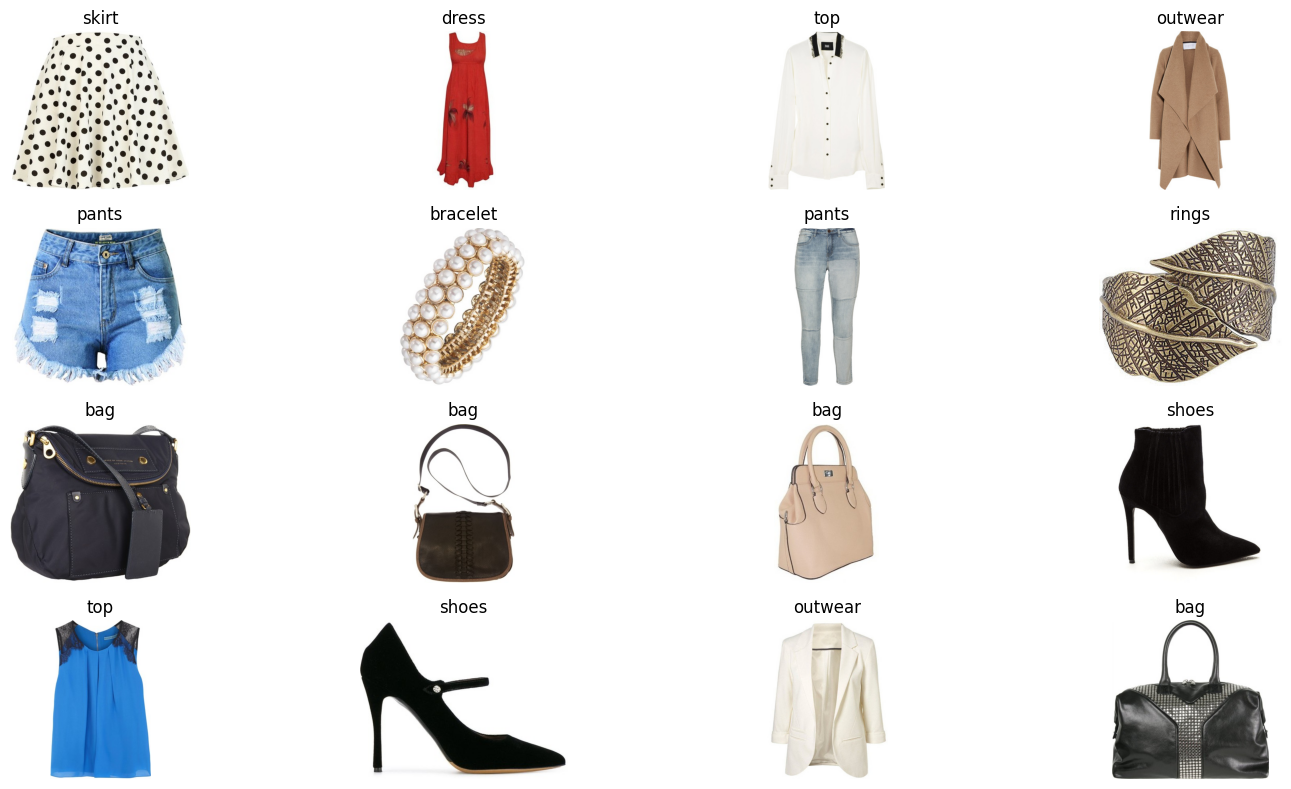

In [7]:
def show_images_grid(dataset, num_images, rows=4, cols=4):
  random_numbers = np.random.randint(0, len(dataset), num_images)
  rows = math.ceil(num_images / 4)
  fig, axes = plt.subplots(rows, cols, figsize=(16, 8))
  axes = axes.flatten()

  for i in range(num_images):
    image, label = dataset.__getitem_no_transform__(random_numbers[i])

    axes[i].imshow(np.array(image))
    axes[i].axis('off')
    axes[i].set_title(f"{rev_labels_dict[label]}")

  plt.tight_layout()
  plt.show()

show_images_grid(dataset, num_images=16)